In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import important libraries

In [2]:
!pip install dill

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle
import warnings
from sklearn.exceptions import FitFailedWarning
from scipy import stats

# Read preprocessed train data

In [4]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed')['target_event']

# Read and transform test data

In [5]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as file:
    test_pipeline = dill.load(file)

In [6]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')['target_event']

# Binary evaluation class

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score

In [8]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy

    def classification_report(self):
        report = classification_report(self.y_test, self.y_pred)
        return report

    def precision_recall_f1(self):
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        return precision, recall, f1
    def roc_score(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        return auc_score

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_visualization(self):
        auc_score = self.roc_score()
        print('=========================')
        print('||','ROC AUC Score:', auc_score.round(2),'||')
        print('=========================')
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_curve_plot(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

# Load all models available

In [9]:
with open('/content/drive/MyDrive/Churn Prediction/log_reg_model.pkl', 'rb') as file:
    log_reg = dill.load(file)

In [10]:
with open('/content/drive/MyDrive/Churn Prediction/random_forest_churn.pkl', 'rb') as file:
    forest = dill.load(file)

In [11]:
with open('/content/drive/MyDrive/Churn Prediction/svm_model_churn.pkl', 'rb') as file:
    svm = dill.load(file)

In [12]:
with open('/content/drive/MyDrive/Churn Prediction/XGBoost_churn.pkl', 'rb') as file:
    boost = dill.load(file)

---
# ***Hard Voting Ensembel***
---

In [40]:
class VotingEnsemble:
    def __init__(self, model1, model2, model3, model4, voting='Hard'):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.model4 = model4
        self.voting = voting
        self.y_pred = None
        self.y_pred_prob = None

    def predict(self, X):
        if self.voting == 'Hard':
            predictions = np.array([model.predict(X) for model in [self.model1, self.model2, self.model3, self.model4]])
            self.y_pred = stats.mode(predictions, axis=0)[0].flatten()
            return self.y_pred

        elif self.voting == 'Soft':
            probabilities = np.array([model.predict_proba(X) for model in [self.model1, self.model2, self.model3, self.model4]])
            self.y_pred_prob = np.mean(probabilities, axis=0)
            self.y_pred = np.argmax(self.y_pred_prob, axis=1)
            return self.y_pred
    def predict_proba(self, X):
        if self.voting == 'Hard':
            raise ValueError("predict_proba is not available for 'Hard' voting. Use 'Soft' voting for probability estimates.")
        elif self.voting == 'Soft':
            if self.y_pred_prob is None:
                self.predict(X)
            return self.y_pred_prob
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

# Create hard voting class object

In [41]:
hard_voting = VotingEnsemble(log_reg, forest, svm, boost, voting='Hard')

# Create the prediction

In [37]:
y_pred_hard = hard_voting.predict(X_test)

# Create evaluation object for hard voting

In [16]:
hard_eval = BinaryClassificationEvaluation(y_test, y_pred_hard)

# Evaluate hard voting from different corner

In [17]:
print(hard_eval.classification_report())

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     15296
           1       0.78      0.70      0.74      7226

    accuracy                           0.84     22522
   macro avg       0.82      0.80      0.81     22522
weighted avg       0.84      0.84      0.84     22522



In [18]:
precision, recall, f1 = hard_eval.precision_recall_f1()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.78
Recall: 0.70
F1 Score: 0.74


---
# ***Soft Voting Ensembel***
---

# Create hard voting class object

In [35]:
soft_voting = VotingEnsemble(log_reg, forest, svm, boost, voting='Soft')

# Create the prediction

In [26]:
y_pred_soft = soft_voting.predict(X_test)
y_pred_soft_proba = soft_voting.predict_proba(X_test)[:,1]

# Create evaluation object for soft voting

In [30]:
soft_eval = BinaryClassificationEvaluation(y_test, y_pred_soft, y_pred_soft_proba)

# Evaluate soft voting from different corner

In [31]:
print(soft_eval.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     15296
           1       0.72      0.76      0.74      7226

    accuracy                           0.83     22522
   macro avg       0.80      0.81      0.80     22522
weighted avg       0.83      0.83      0.83     22522



|| ROC AUC Score: 0.88 ||


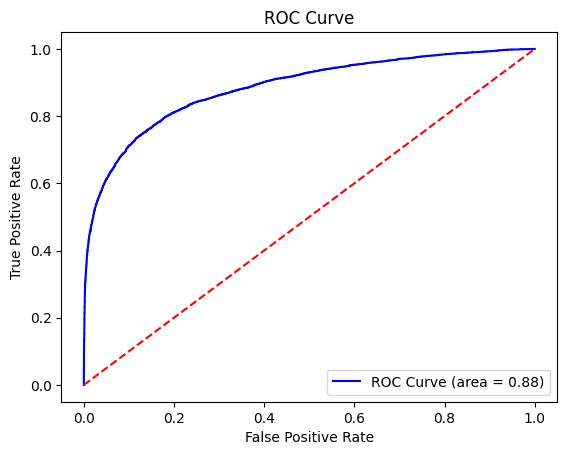

In [33]:
soft_eval.roc_curve_visualization()

# Since hard voting does better performance i save only hard voting ensemble method

In [42]:
hard_voting.save_model('/content/drive/MyDrive/Churn Prediction/hard_voting_model_churn.pkl')